# TF Hub Single flowers

Extract features with one of the tfhub models on the flowers dataset and compute/plot the TSNE of those features.

In [56]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
# print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

model_name = "mobilenet_v3_small_100_224"  # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
    "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
    "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
    "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
    "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
    "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
    "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
    "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
    "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
    "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
    "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
    "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
    "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
    "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
    "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
    "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
    "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
    "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
    "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
    "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
    "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
    "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
    "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
    "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
    "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
    "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
    "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
    "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
    "efficientnet_b0": 224,
    "efficientnet_b1": 240,
    "efficientnet_b2": 260,
    "efficientnet_b3": 300,
    "efficientnet_b4": 380,
    "efficientnet_b5": 456,
    "efficientnet_b6": 528,
    "efficientnet_b7": 600,
    "inception_v3": 299,
    "inception_resnet_v2": 299,
    "nasnet_large": 331,
    "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32

print(f"GPU is available: {tf.test.is_built_with_cuda()}")
print(f"GPU device: {tf.config.list_physical_devices('GPU')}")

TF version: 2.5.0
Hub version: 0.10.0
Selected model: mobilenet_v3_small_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5
Input size (224, 224)
GPU device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available: True


## Get the data

In [33]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

datagen_kwargs = dict(rescale=1./255)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    data_dir, shuffle=False, **dataflow_kwargs)

# datagen_kwargs = dict(rescale=1./255, validation_split=.20)
# dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
#                    interpolation="bilinear")

# valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     **datagen_kwargs)
# valid_generator = valid_datagen.flow_from_directory(
#     data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

# do_data_augmentation = False
# if do_data_augmentation:
#   train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#       rotation_range=40,
#       horizontal_flip=True,
#       width_shift_range=0.2, height_shift_range=0.2,
#       shear_range=0.2, zoom_range=0.2,
#       **datagen_kwargs)
# else:
#   train_datagen = valid_datagen
# train_generator = train_datagen.flow_from_directory(
#     data_dir, subset="training", shuffle=True, **dataflow_kwargs)

print(f"Generator shape 0: {np.shape(next(train_generator)[0])}")
print(f"Generator shape 1: {np.shape(next(train_generator)[1])}")

Found 3670 images belonging to 5 classes.
Generator shape 0: (32, 224, 224, 3)
Generator shape 1: (32, 5)


In [34]:
len(train_generator.classes)

3670

## Build a new model

In [35]:
print("Building model with", model_handle)
model2 = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle)
])
model2.build((None,)+IMAGE_SIZE+(3,))
model2.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1024)              1529968   
Total params: 1,529,968
Trainable params: 0
Non-trainable params: 1,529,968
_________________________________________________________________


## Get the predicted features

In [36]:
results = model2.predict(train_generator)
print(len(results))
print(np.shape(results))

3670
(3670, 1024)


## Compute the TSNE

In [43]:
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(results)
tsne.shape

(3670, 2)

## Plot without masking

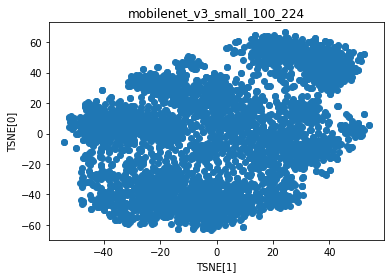

In [44]:
plt.figure()
plt.ylabel("TSNE[0]")
plt.xlabel("TSNE[1]")
plt.title(model_name)
plt.scatter(tsne[:, 0], tsne[:, 1])
plt.savefig(model_name + ".jpg")

## Plot with masking

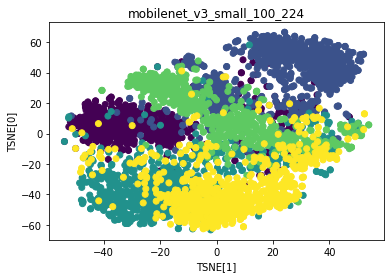

In [45]:
plt.figure()
plt.ylabel("TSNE[0]")
plt.xlabel("TSNE[1]")
plt.title(model_name)
plt.scatter(tsne[:, 0], tsne[:, 1], c = train_generator.classes)
plt.savefig(model_name + ".jpg")

## Save data

In [53]:
# np.savetxt("foo.csv", results, delimiter=",")

df = pd.DataFrame(results)
# %timeit 
df.to_hdf('test.h5','df',mode='w')

14.6 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
